In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# data 폴더 csv 불러올때 파일명확인
from glob import glob 

# type 변환
from datetime import datetime, timedelta

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# 데이터 시각화
import plotly
import random

line_color = ['#FFBF00', '#FF7F50', '#DE3163', 
             '#9FE2BF', '#40E0D0', '#6495ED', 
             '#117A65', '#2471A3', '#CCCCFF', 
             '#8E44AD', '#CD5C5C', '#F08080', 
             '#FA8072', '#E9967A', '#FFA07A', ]

# for문 진행상황 tracking
from tqdm import tqdm

# 전처리
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#ML 알고리즘
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor

# 모델 튜닝 및 평가
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Feature 중요도 _ LightGBM
from lightgbm import plot_importance

# 경고 무시
import sys
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import joblib 
import os

import random
import requests
import calendar
import time

C:\Miniconda\envs\py38_default\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# 분할된 test set을 한 파일로 모으는 과정(어떤 이유에서인지 예선과 달리 본선에서 이 과정이 상당히 느려짐)
# csv 파일로 만들어 './test_raw.csv' 경로에 저장해두었으니, 이 셀은 실행시킬 필요 없음.
def read_csv_by_dir(path):
    df_raw = pd.DataFrame()
    #os.listdir()은 해당 경로에 있는 파일들을 리스트로 만들어줌
    for files in tqdm(os.listdir(path)):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path, files]))
        df_raw = pd.concat((df_raw, df), axis=0)
    return df_raw

path = 'Z:/team/과제2_dataset/dataset'
test_raw = read_csv_by_dir('/'.join([path, 'test']))
test_raw.to_csv('./test_raw.csv')

In [2]:
#train set과 제출 파일을 불러오는 과정
train_raw = pd.read_csv('Z:/team/과제2_dataset/dataset/train/train.csv')
submission_sample_raw = pd.read_csv('Z:/team/과제2_dataset/dataset/submission_sample.csv')

#따로 병합해서 저장해놓은 test set을 불러오는 과정
test_raw =pd.read_csv('Z:/team/과제2_dataset/dataset/test_raw/test_raw.csv')
test_raw = test_raw.sort_values(by='TIME')
test_raw = test_raw.reset_index(drop=True)
test_raw = test_raw.drop(["Unnamed: 0"], axis=1)

In [23]:
# 원본(raw)은 유지하기
train = train_raw.copy()
test = test_raw.copy()
submission = submission_sample_raw.copy()

In [24]:
# time컬럼을 문자형에서 날짜 타입으로 변경
train.TIME = pd.to_datetime(train['TIME'])
test.TIME = pd.to_datetime(test['TIME'])
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

#밀리초 단위가 5밀리초씩 늦은 row가 있어서 이를 정각으로 맞춰주기 위한 작업
from datetime import datetime, timedelta
train['MINUTE']=train['TIME'].dt.minute
train['MOD']=train['MINUTE']%10
train.loc[train['MOD'] == 9, 'TIME'] = train['TIME']+timedelta(milliseconds=5)
train.drop(['MINUTE','MOD'], axis=1, inplace=True)

test['MINUTE']=test['TIME'].dt.minute
test['MOD']=test['MINUTE']%10
test.loc[test['MOD'] == 9, 'TIME'] = test['TIME']+timedelta(milliseconds=5)
test.drop(['MINUTE','MOD'], axis=1, inplace=True)

In [25]:

#기상청 데이터를 지역 3개를 선정하여 csv파일로 저장해놓았다.
#이 csv 파일을 dataframe 형식으로 불러오고, 전처리 하는 과정

def weather_generator(location):
    #동해, 원덕, 궁촌 3개 중 1개만 실행
    if location == "donghae":
        #동해 기상데이터 불러오기
        df_2019 = pd.read_csv('Z:/team/donghae_weather/donghae_weather_2019.csv', encoding='cp949')
        df_2020 = pd.read_csv('Z:/team/donghae_weather/donghae_weather_2020.csv', encoding='cp949')
        df_2021 = pd.read_csv('Z:/team/donghae_weather/donghae_weather_2021.csv', encoding='cp949')
        weather_test = pd.read_csv('Z:/team/donghae_weather/donghae_weather_test.csv', encoding='cp949')
        
    elif location == "wondeok":
        #원덕읍 기상데이터 불러오기
        df_2019 = pd.read_csv('Z:/team/1111_upload/wondeok_weather_2019.csv', encoding='cp949')
        df_2020 = pd.read_csv('Z:/team/1111_upload/wondeok_weather_2020.csv', encoding='cp949')
        df_2021 = pd.read_csv('Z:/team/1111_upload/wondeok_weather_2021.csv', encoding='cp949')
        weather_test = pd.read_csv('Z:/team/1111_upload/wondeok_weather_test.csv', encoding='cp949')

    elif location == "goongchon":
        #궁촌 기상데이터 불러오기
        df_2019 = pd.read_csv('Z:/team/1111_upload/goongchon_weather_2019.csv', encoding='cp949')
        df_2019 = df_2019[:8661]
        df_2020 = pd.read_csv('Z:/team/1111_upload/goongchon_weather_2020.csv', encoding='cp949')
        df_2020 = df_2020[:8784]
        df_2021 = pd.read_csv('Z:/team/1111_upload/goongchon_weather_2021.csv', encoding='cp949')
        df_2021 = df_2021[:744]
        weather_test = pd.read_csv('Z:/team/1111_upload/goongchon_weather_test.csv', encoding='cp949')
        weather_test = weather_test[:7343]

    #train set에 쓰이는 기상 데이터 3개년도를 합치고 가공
    donghae_result = pd.concat([df_2019, df_2020, df_2021], ignore_index=True)
    donghae_result.rename(columns={'일시':'TIME'}, inplace=True)
    donghae_result['TIME']=pd.to_datetime(donghae_result['TIME'])

    #test set에 쓰이는 기상 데이터 가공
    weather_test.rename(columns={'일시':'TIME'}, inplace=True)
    weather_test['TIME']=pd.to_datetime(weather_test['TIME'])

    #원하는 컬럼만 갖고오기
    donghae_temp_train = donghae_result.loc[:, ['TIME', '기온(°C)', '습도(%)', '증기압(hPa)', '현지기압(hPa)']]
    weather_test = weather_test.loc[:, ['TIME', '기온(°C)', '습도(%)', '증기압(hPa)', '현지기압(hPa)']]

    #결측치 보간
    donghae_temp_train = donghae_temp_train.set_index('TIME')
    donghae_temp_train = donghae_temp_train.interpolate(method = 'time')
    donghae_temp_train.reset_index(drop = False, inplace = True)

    #결측치 보간
    weather_test = weather_test.set_index('TIME')
    weather_test = weather_test.interpolate(method = 'time')
    weather_test.reset_index(drop = False, inplace = True)

    print("기상청 데이터를 10분단위로 생성합니다.")
    #날씨데이터는 정각의 데이터밖에 없다.
    #따라서 10분 단위로 데이터를 생성해주기 위한 작업이다.
    weather_test_ = weather_test
    new_row = pd.DataFrame({'TIME':[np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]}
                          )
    j=0
    
    #정각과 정각 사이에 10~50분 총 5행을 넣어주는 작업
    for i in tqdm(range(1, weather_test_.shape[0]+1)):
        weather_test_ = pd.concat([weather_test_.iloc[:i+j], new_row, weather_test_.iloc[i+j:]], ignore_index=True)
        j+=5

    weather_test__ = weather_test_

    for i in tqdm(range(weather_test__.shape[0])):
        weather_test__.iloc[i+1:i+2,[0]] = weather_test__.iloc[i:i+1,[0]]+timedelta(minutes=10)
    weather_test__ = weather_test__.set_index('TIME')
    weather_test__ = weather_test__.interpolate(method = 'time')
    weather_test__.reset_index(drop = False, inplace = True)

    weather_test = weather_test__
    print("기상청 데이터 생성이 완료됐습니다.")

    weather_test['TIME']=pd.to_datetime(weather_test['TIME'])
    
    global train
    global test
    
    train_temp_join = pd.merge(train, donghae_temp_train, left_on='TIME', right_on='TIME', how='left')
    test_temp_join = pd.merge(test, weather_test, left_on='TIME', right_on='TIME', how='left')

    train_temp_join = train_temp_join.set_index('TIME')
    train_temp_join = train_temp_join.interpolate(method='time')
    train_temp_join.reset_index(drop = False, inplace = True)
    train_temp_join.rename(columns={'기온(°C)':'TEMP', '습도(%)':'HUMID', '증기압(hPa)':'VAPOR', '현지기압(hPa)':'PRESS'}, inplace=True)
    test_temp_join.rename(columns={'기온(°C)':'TEMP', '습도(%)':'HUMID', '증기압(hPa)':'VAPOR', '현지기압(hPa)':'PRESS'}, inplace=True)

    #날씨 정보가 추가된 버전으로 train 덮어쓰기
    train = train_temp_join
    #날씨 정보가 추가된 버전으로 test 덮어쓰기
    test = test_temp_join
    
    return train, test

train, test = weather_generator("donghae")

기상청 데이터를 10분단위로 생성합니다.


100%|██████████████████████████████████████████████████████████████████████████| 44064/44064 [00:32<00:00, 1358.38it/s]


기상청 데이터 생성이 완료됐습니다.


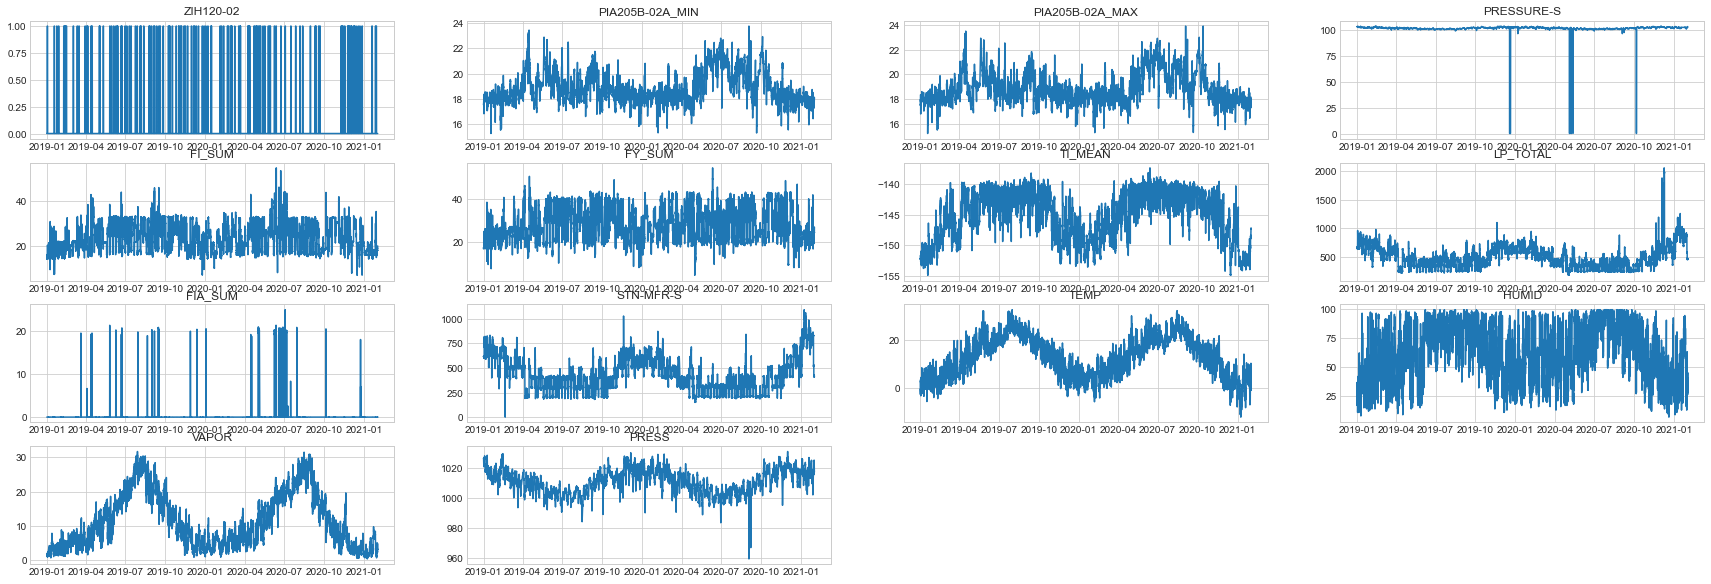

In [69]:
#전체 변수들의 그래프를 그려보고 추이를 확인
#이상치가 의심되는 그래프들은 해당 그래프 하나만 크게 다시 그려보자

plot_list = list(train.columns)
plot_list.remove('TIME')

plt.figure(figsize=(30,10))

idx=1
for var in plot_list:
    plt.subplot(4,4,idx)
    plt.plot(train['TIME'], train[var])
    plt.title(var)
    idx+=1

In [19]:
#이상치 판독 함수
# Q3 + 1.5*IQR보다 크거나 Q1 - 1.5*IQR보다 작으면 이상치로 보기로 했음.
def outlier(sets, column):
    q1 = sets[column].quantile(0.25)
    q3 = sets[column].quantile(0.75)
    iqr = q3-q1
    top_fence = sets[sets[column] > q3+1.5*iqr].shape[0]
    bottom_fence = sets[sets[column] < q1-1.5*iqr].shape[0] 
    print("----{}----".format(column))
    print("이상치 범위는 {:.3f}이상, {:.3f}이하".format(q3+1.5*iqr,q1-1.5*iqr))
    print("큰 이상치 값의 개수는 {}개이고 전체 중 {:.3f}%".format(top_fence, (top_fence/sets.shape[0])*100))
    print("작은 이상치 값의 개수는 {}개이고 전체 중 {:.3f}%".format(bottom_fence, (bottom_fence/sets.shape[0])*100))


<AxesSubplot:xlabel='TIME', ylabel='PRESSURE-S'>

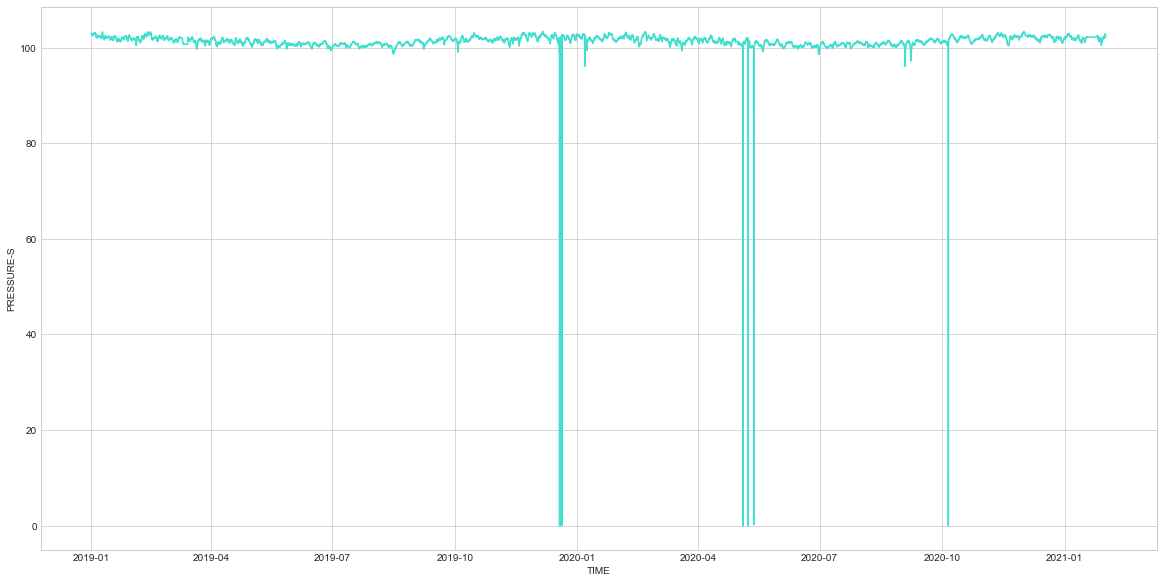

In [37]:
#눈에 띄게 이상한 그래프는 따로 그려보도록 하자.

# PRESSURE-S 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=train['TIME'], y=train['PRESSURE-S'], ax=ax, color=random.choice(line_color))

# PRESSURE-S 중 0인 값
# print(train[train['PRESSURE-S']==0].shape[0]) #7개.-> 완전 무작위 결측(MCAR)
# PRESSURE-S 중 80보다 낮은 값
# print(train[train['PRESSURE-S']<80].shape[0]) #38개.-> 완전 무작위 결측(MCAR)

<AxesSubplot:xlabel='TIME', ylabel='STN-MFR-S'>

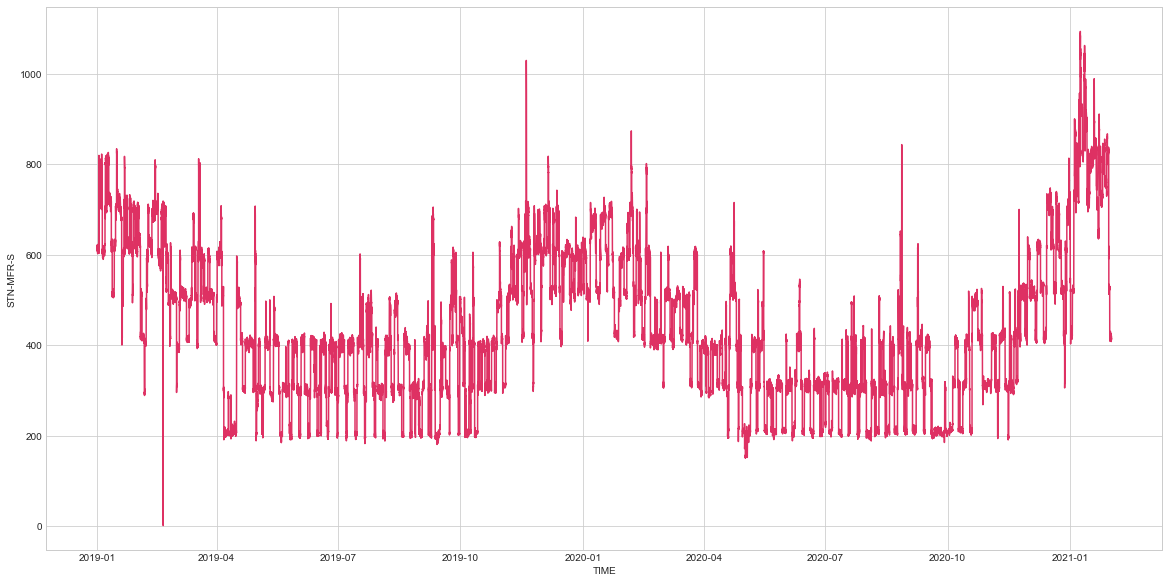

In [36]:
# STN-MFR-S 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=train['TIME'], y=train['STN-MFR-S'], ax=ax, color=random.choice(line_color))

In [26]:
#Outlier로 잡히지 않았지만, 그래프 보면 극단적으로 낮은 부분이 보임
#train[train['STN-MFR-S']<2] # 1이 4개나 있음. 오기입된 것으로 추정. -> 완전 무작위 결측(MCAR)

train.loc[train['STN-MFR-S'] < 2, 'STN-MFR-S'] = np.NaN
train = train.set_index('TIME')
train = train.interpolate(method='time')
train.reset_index(drop=False, inplace=True)

In [27]:
#위 시각화와 판독함수로 봤을 때, 이상치 보간이 필요한 columns list를 선정했음.
remove_list = ["PRESS", "PRESSURE-S", "LP_TOTAL", "STN-MFR-S", "FI_SUM"] 

#이상치 보간해주는 함수
def remove_outlier(remove_list,method_):
    global train
    for var in remove_list:
        q1 = train[var].quantile(0.25)
        q3 = train[var].quantile(0.75)
        iqr = q3-q1
        train.loc[train[var]<=q1-1.5*iqr, var] = np.NaN
        train.loc[train[var]>=q3+1.5*iqr, var] = np.NaN
        train = train.set_index('TIME')
        train = train.interpolate(method=method_)
        train.reset_index(drop=False, inplace=True)
    return train

train = remove_outlier(remove_list,"time")

<AxesSubplot:xlabel='TIME', ylabel='PRESSURE-S'>

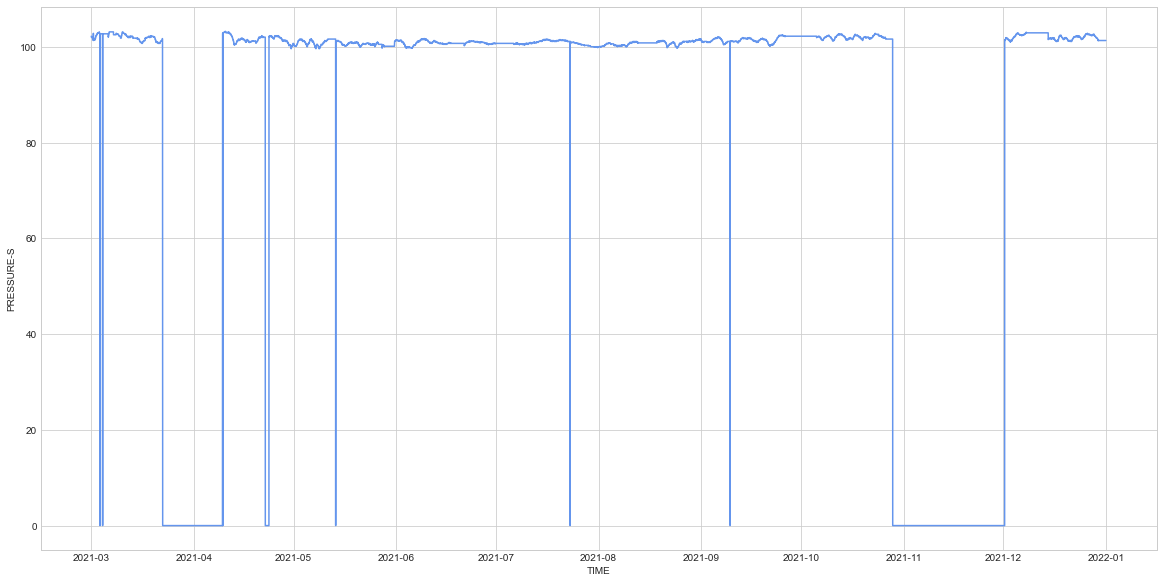

In [33]:
#test set에는 이상치 문제가 있는지 확인해볼 것.

# test set PRESSURE-S 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=test['TIME'], y=test['PRESSURE-S'], ax=ax, color=random.choice(line_color))

In [11]:
# test[test['PRESSURE-S']==0].shape[0] #0값이 1823개나 됨. 데이터에 상당한 오류가 있는 것으로 보임
outlier(test, 'PRESSURE-S')

#test set에 이상치가 너무 많음.
# 대안1) 이 정도 수준이면 test set을 columns에서 과감히 삭제!
# 대안2) train set의 통계 정보로 보간하기(data leakage 예방)
# 대안3) PRESSURE-S는 drop하고 이상치가 없는 기상청 데이터(현지기압)를 끌고 와서 새로운 변수로 만들기! <- 이 방식 채택하여 앞서 기상청 데이터에서 현지기압 변수를 불러온 것.

----PRESSURE-S----
이상치 범위는 103.800이상, 98.200이하
큰 이상치 값의 개수는 0개이고 전체 중 0.000%
작은 이상치 값의 개수는 5739개이고 전체 중 17.366%


<AxesSubplot:xlabel='TIME', ylabel='LP_TOTAL'>

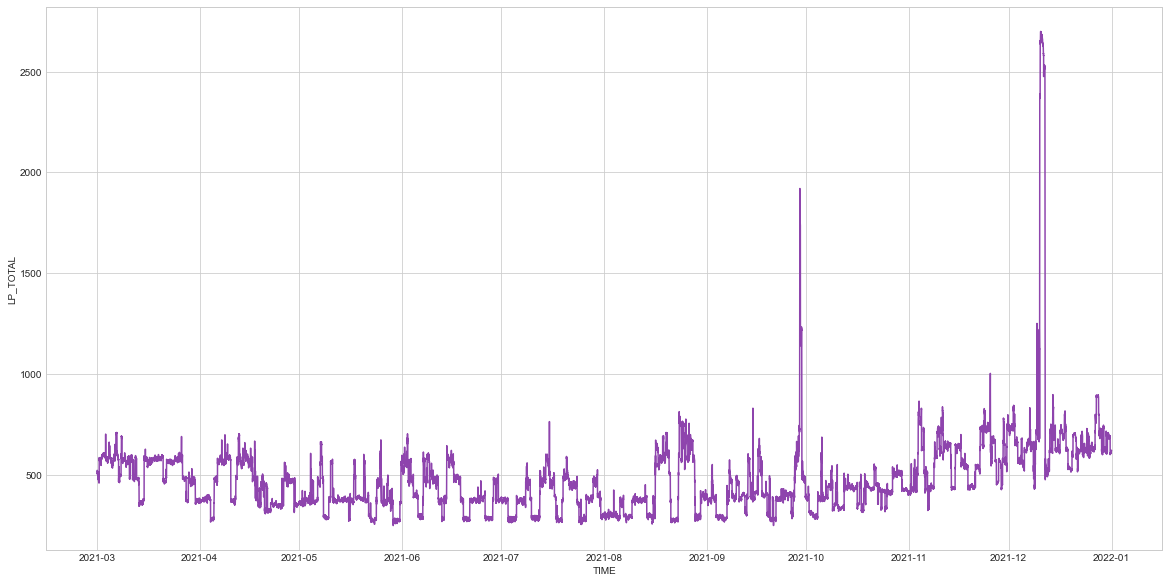

In [35]:
# test set LP_TOTAL 그래프 그리기
f, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(x=test['TIME'], y=test['LP_TOTAL'], ax=ax, color=random.choice(line_color))

In [28]:
# LP_TOTAL은 '재순환 및 재순환 회수를 거쳐 재액화기로 인입되는 LNG의 유량'이다.
# 21년 10월, 12월 경 비정상적으로 값이 커진다.
# 하지만 이에 따른 다른 변수, 타겟값의 연쇄적인 변화는 없다. -> 결측치로 생각

#test set의 lP_TOTAL값 중 큰 이상치는 data leakage를 막기 위해 train set의 3분위수로 대체
#869.165(큰 이상치) 이상을 train LP_TOTAL의 3분위수로 대체!

LP_TOTAL_3qt = train['LP_TOTAL'].quantile(0.75)
test.loc[test['LP_TOTAL']>=869.165, 'LP_TOTAL'] = LP_TOTAL_3qt

In [29]:
train['HOUR'] = train['TIME'].dt.hour #시간 변수 추가
test['HOUR'] = test['TIME'].dt.hour #시간 변수 추가
train['MONTH'] = train['TIME'].dt.month #월 변수 추가
test['MONTH'] = test['TIME'].dt.month #월 변수 추가
train['WEEK'] = train['TIME'].dt.weekofyear #주차 변수 추가
test['WEEK'] = test['TIME'].dt.weekofyear #주차 변수 추가
train['DAY'] = train['TIME'].dt.dayofyear #일 변수 추가
test['DAY'] = test['TIME'].dt.dayofyear #일 변수 추가
train['WEEKDAY'] = train['TIME'].dt.weekday #요일 변수 추가
test['WEEKDAY'] = test['TIME'].dt.weekday #요일 변수 추가

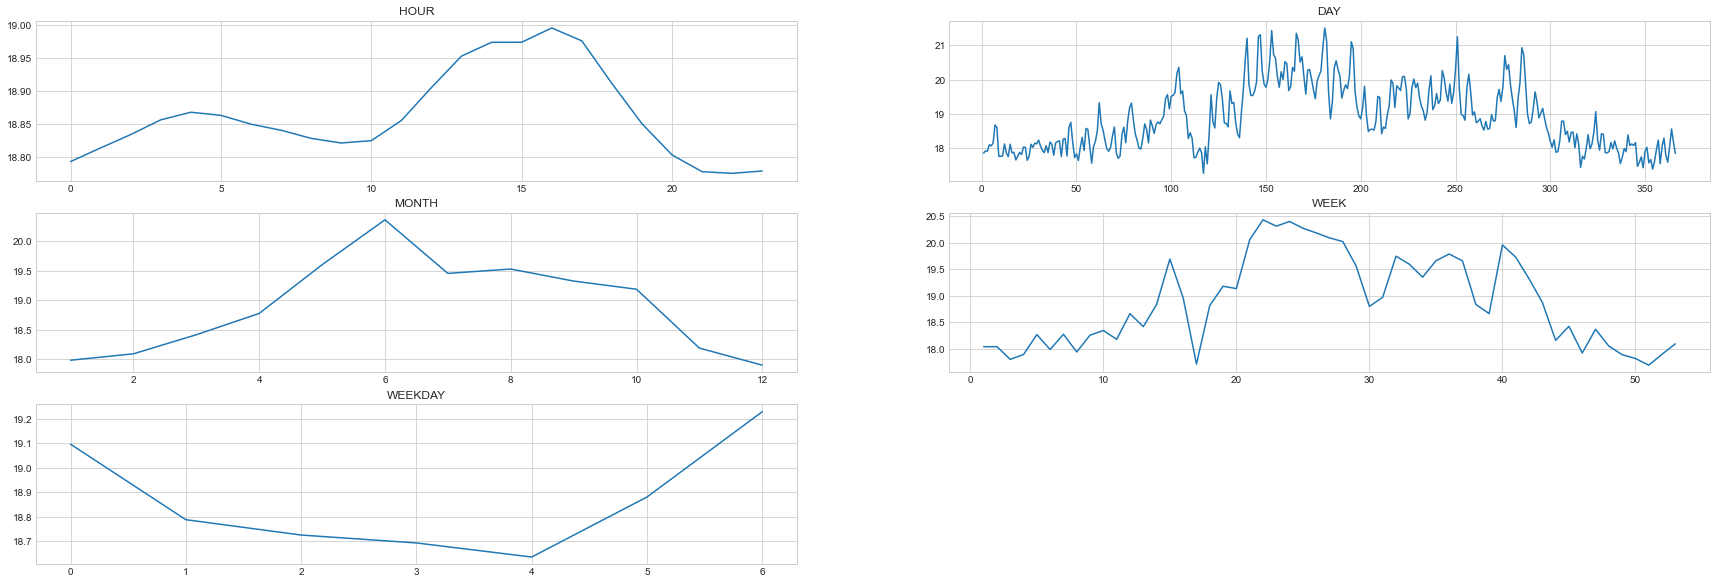

In [43]:
draw_list = ["HOUR","DAY","MONTH","WEEK","WEEKDAY"]

#시간 변수를 x축에, 압력 최댓값을 y축에 두고 그린 line plot 함수
def plot_per_time(sets, draw_list):
    plt.figure(figsize=(30,10))
    idx=1
    for var in draw_list:
        groupby = sets.groupby(var).mean()
        groupby.reset_index(inplace=True)
        plt.subplot(3,2,idx)
        plt.plot(groupby[var], groupby['PIA205B-02A_MAX'])
        plt.title(var)
        idx+=1
        
plot_per_time(train, draw_list)

In [30]:
#시간 변수의 주기성을 알기 위해 시간을 푸리에 특징으로 변환
#예를 들어 시간은 0~23이라는 int type으로 표현되는데 이렇게 되면 1월 1일 23시와 1월 2일 00시는 실제로 한 시간의 차이를 가짐에도 23의 차이를 갖는 꼴이 된다.
#이를 해결해주고자 삼각함수로 변환하여 시간이 연속성을 갖게 하자.
train['cos_day'] = np.cos(2*np.pi*(train.DAY/365))
test['cos_day'] = np.cos(2*np.pi*(test.DAY/365))
train['cos_hour'] = np.cos(2*np.pi*(train.HOUR/24))
test['cos_hour'] = np.cos(2*np.pi*(test.HOUR/24))


# 평가에 쓰이는 데이터는 현 시점보다 과거의 데이터이다.
# 따라서 학습 시에도 10분~60분 이전의 lag 데이터를 만들어줄 것임.

column_list = list(train.columns)
column_list.remove('TIME')
column_list_ = column_list

#TIME 변수를 제외하고 모든 변수에 대해 10분 전 LAG1 데이터를 만들어준다.
for column in column_list_:
    train['LAG1_{}'.format(column)] = train[column].shift(1)
    
column_list_.remove('PIA205B-02A_MIN')
column_list_.remove('PIA205B-02A_MAX')
remove_list_ = column_list_

#타겟 2개와 새로 만든 LAG1 변수들을 제외하고 나머지 변수들을 drop한다.
train.drop(remove_list_,axis=1,inplace=True)

#과거 압력값은 꽤 중요한 변수이기에 다른 변수와 달리 10~60분의 모든 데이터를 활용한다. 즉, LAG1~LAG6까지 만든다.
for n in range(2,7):
    for PIA in ['PIA205B-02A_MIN','PIA205B-02A_MAX']:
        train['LAG{}_{}'.format(n, PIA)] = train[PIA].shift(n)

#LAG의 변화량 역시도 중요한 요소로 작용할 것이기에 LAG1과 LAG2의 차를 변수로 만든다.
#lAG1과 LAG2의 차
train['MIN_DIFF_12'] = train['LAG1_PIA205B-02A_MIN']-train['LAG2_PIA205B-02A_MIN']
train['MAX_DIFF_12'] = train['LAG1_PIA205B-02A_MAX']-train['LAG2_PIA205B-02A_MAX']


#lAG1과 LAG2의 차의 제곱
train['MIN_DIFF_12SQ'] = train['MIN_DIFF_12']**2
train['MAX_DIFF_12SQ'] = train['MAX_DIFF_12']**2


#lAG1과 LAG2의 곱
train['MIN_DIFF_12X'] = train['LAG1_PIA205B-02A_MIN']*train['LAG2_PIA205B-02A_MIN']
train['MAX_DIFF_12X'] = train['LAG1_PIA205B-02A_MAX']*train['LAG2_PIA205B-02A_MAX']

#LAG1 MIN과 LAG1 MAX의 차
train['DIFF_MAXMIN'] = train['LAG1_PIA205B-02A_MAX'] - train['LAG1_PIA205B-02A_MIN']


#shift로 인해 변수가 NaN값으로 유실된 row는 버려준다.
train_ = train[6:]

#타겟은 y에, 변수는 x에 넣어준다.
y = train_.iloc[:,1:3]
x = train_.iloc[:,3:]



#test_data 만들기. 평가(predict)에 쓰이는 데이터이다.
#예측시점의 10분 전 변수를 모두 활용하고, 압력값은 10~60분 전까지 활용한다.
#코드 원리는 상기한 train의 원리와 동일하다.


column_list = list(test.columns)
column_list.remove('TIME')
column_list_ = column_list

for column in column_list_:
    test = test.rename(columns={column:'LAG1_{}'.format(column)})

for n in range(1,6):
    for PIA in ['LAG1_PIA205B-02A_MIN','LAG1_PIA205B-02A_MAX']:
        test['LAG{}_{}'.format(n+1, PIA[5:])] = test[PIA].shift(n)


#lAG1과 LAG2의 차
test['MIN_DIFF_12'] = test['LAG1_PIA205B-02A_MIN']-test['LAG2_PIA205B-02A_MIN']
test['MAX_DIFF_12'] = test['LAG1_PIA205B-02A_MAX']-test['LAG2_PIA205B-02A_MAX']


#lAG1과 LAG2의 차의 제곱
test['MIN_DIFF_12SQ'] = test['MIN_DIFF_12']**2
test['MAX_DIFF_12SQ'] = test['MAX_DIFF_12']**2


#lAG1과 LAG2의 곱
test['MIN_DIFF_12X'] = test['LAG1_PIA205B-02A_MIN']*test['LAG2_PIA205B-02A_MIN']
test['MAX_DIFF_12X'] = test['LAG1_PIA205B-02A_MAX']*test['LAG2_PIA205B-02A_MAX']

#LAG1 MIN과 LAG1 MAX의 차
test['DIFF_MAXMIN'] = test['LAG1_PIA205B-02A_MAX'] - test['LAG1_PIA205B-02A_MIN']

test_ = test[5::6]
test_.drop('TIME',axis=1,inplace=True)
test_.reset_index(drop=True,inplace=True)
test_with_sub = pd.concat((submission,test_), axis=1)
test_data = test_with_sub.iloc[:,3:]

#columns 순서 train data와 동일하게 맞추기
test_data = test_data.reindex(columns=x.columns)

#중요도 낮다고 판단한 변수는 drop한다.
#test set에 이상치가 많은 변수는 보간을 고민하다가 과감히 없앴음.
x = x.drop(["LAG1_ZIH120-02", "LAG1_HOUR", "LAG1_PRESSURE-S", "LAG1_MONTH", "LAG1_WEEK", "LAG1_DAY", 
            'LAG1_PRESS', 'LAG1_VAPOR', 'LAG1_HUMID', 'LAG1_FY_SUM', 'LAG1_FIA_SUM', 'LAG1_TI_MEAN', 'LAG1_LP_TOTAL'], axis=1)
test_data = test_data.drop(["LAG1_ZIH120-02", "LAG1_HOUR", "LAG1_PRESSURE-S", "LAG1_MONTH", "LAG1_WEEK", 
                            "LAG1_DAY", 'LAG1_PRESS', 'LAG1_VAPOR', 'LAG1_HUMID', 'LAG1_FY_SUM', 'LAG1_FIA_SUM', 'LAG1_TI_MEAN', 'LAG1_LP_TOTAL'], axis=1)

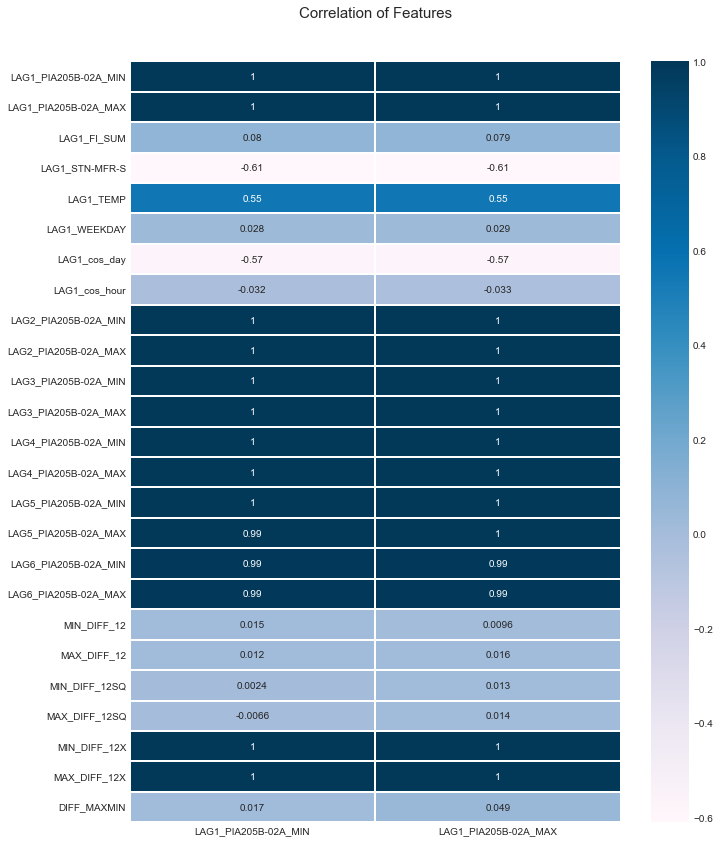

In [34]:
#상관관계 분석

def draw_corr_heatmap(data):
    colormap = plt.cm.PuBu
    plt.figure(figsize=(11,14))
    plt.title("Correlation of Features", y=1.05, size=15)
    sns.heatmap(data.corr().loc[:,['LAG1_PIA205B-02A_MIN','LAG1_PIA205B-02A_MAX']], cmap=colormap, linewidths=0.03, linecolor="white", annot=True)

draw_corr_heatmap(x)

#단순히 상관관계만 보고 변수를 SELECT or DROP하는 건 무리가 있음!

In [ ]:
start = time.time()

# 10 fold로 교차검증을 수행
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
folds = []

# train과 validation의 index를 나누기
for train_idx, val_idx in kfold.split(x,y):
    folds.append((train_idx, val_idx))

# 10번의 교차검증을 통해 만들 10개의 모델을 딕셔너리에 저장해놓을 것.
XGB_model_dict = {}

#10번에 걸친 MAE 점수 역시도 리스트에 저장
MAE = []

for f in range(10):
    print("----------{}회째 folds-----------".format(f+1))
    train_idx, val_idx = folds[f]

    x_train, x_val, y_train, y_val = x.iloc[train_idx], x.iloc[val_idx], y.iloc[train_idx], y.iloc[val_idx]

    XGB_model = XGBRegressor(n_estimators=2000,
                 min_child_weight=4,
                 learning_rate=0.02,
                 max_depth=20,
                 n_jobs=-1,
                     alpha=0.1,
                     colsample_bytree=0.9,
                     subsample=1.0,
                eval_metric='mae')

    # 모델 훈련
    XGB_model.fit(x_train, y_train)
    
    y_pred = XGB_model.predict(x_val)
    mae = mean_absolute_error(y_val, y_pred)
    MAE.append(mae)
    
    # K번째 교차검증의 MAE 스코어 출력
    print("{} fold MAE score: {:.8f}".format(f+1,mae))
    
    # K번째 모델을 딕셔너리에 저장
    XGB_model_dict[f] = XGB_model

MAE_mean = np.array(MAE)
print("---------------------------")
print("k-fold MAE mean: {:.8f}".format(np.mean(MAE_mean)))


submission.iloc[:,1:]=0

#총 10개의 모델을 호출해가며 그 평균값을 제출파일에 저장하는 과정
for fold in range(10):
    submission.iloc[:,1:] += XGB_model_dict[fold].predict(test_data)/10
    
print("runtime:", time.time()-start)

In [584]:
# 제출 파일 csv로 저장
submission.to_csv('XGB_answer_11231700.csv', index=False)

In [35]:
# 위 코드는 런타임 시간이 1시간을 넘어가므로, 미리 dump 해놓은 결과물을 딕셔너리로 불러놓으면 검증이 수월할 것 같습니다.
# 아래 코드를 실행하면 최종점수에 근사한 값이 나올 것입니다!

final_model_dict = joblib.load('./XGB_1123_02597_best.pkl')

submission.iloc[:,1:] = 0
for fold in range(10):
    submission.iloc[:,1:] += final_model_dict[fold].predict(test_data)/10

In [36]:
#사용한 변수 목록
x.columns

Index(['LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM',
       'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day',
       'LAG1_cos_hour', 'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX',
       'LAG3_PIA205B-02A_MIN', 'LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN',
       'LAG4_PIA205B-02A_MAX', 'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX',
       'LAG6_PIA205B-02A_MIN', 'LAG6_PIA205B-02A_MAX', 'MIN_DIFF_12',
       'MAX_DIFF_12', 'MIN_DIFF_12SQ', 'MAX_DIFF_12SQ', 'MIN_DIFF_12X',
       'MAX_DIFF_12X', 'DIFF_MAXMIN'],
      dtype='object')

In [ ]:
# 사용한 변수 목록

#'LAG1_PIA205B-02A_MIN', 'LAG1_PIA205B-02A_MAX', 'LAG1_FI_SUM', 'LAG1_STN-MFR-S', 'LAG1_TEMP', 'LAG1_WEEKDAY', 'LAG1_cos_day', 'LAG1_cos_hour'
# ㄴ> 10분 전 압력값, FI_SUM, STN-MFR-S, 기온, 요일, 연속형 날짜, 연속형 시간
#'LAG2_PIA205B-02A_MIN', 'LAG2_PIA205B-02A_MAX', 'LAG3_PIA205B-02A_MIN','LAG3_PIA205B-02A_MAX', 'LAG4_PIA205B-02A_MIN', 'LAG4_PIA205B-02A_MAX', 'LAG5_PIA205B-02A_MIN', 'LAG5_PIA205B-02A_MAX', 'LAG6_PIA205B-02A_MIN','LAG6_PIA205B-02A_MAX', 
# ㄴ> 20~60분 전 압력값
# 'MIN_DIFF_12', 'MAX_DIFF_12', 'MIN_DIFF_12SQ', 'MAX_DIFF_12SQ', 'MIN_DIFF_12X', 'MAX_DIFF_12X', 'DIFF_MAXMIN'
# ㄴ> 

# -> 0.02597  fold 안 했을 때가 0.02603이라 별반 차이가 없는데 시간차이는 10배(9801초)가 나서 fold를 안하는 게 나을지도?

<AxesSubplot:title={'center':'cover'}, xlabel='F score', ylabel='Features'>

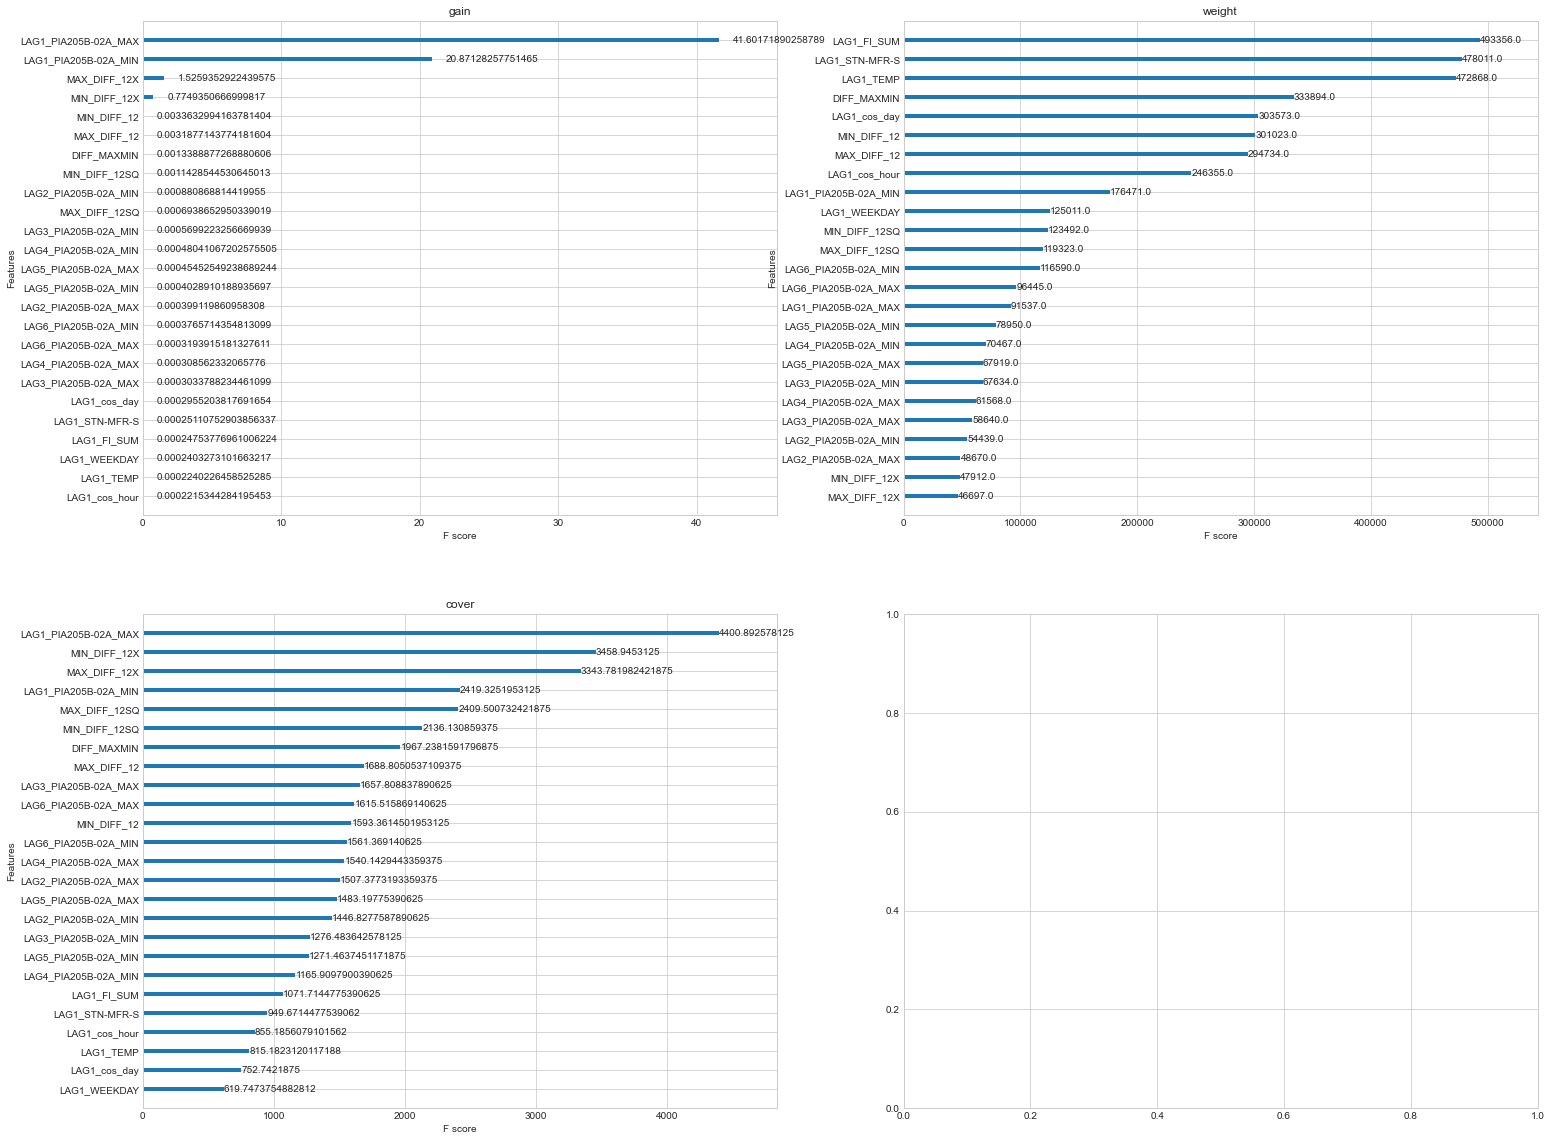

In [59]:
#변수 중요도
XGB_model = final_model_dict[0]
from xgboost import plot_importance

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,20))
axes = [ax for row_axes in axes for ax in row_axes]

plot_importance(XGB_model, importance_type='gain', title='gain', ax=axes[0])
plot_importance(XGB_model, importance_type='weight', title='weight', ax=axes[1])
plot_importance(XGB_model, importance_type='cover', title='cover', ax=axes[2])
